In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

In [ ]:
from keras.layers import Input, LSTM, Dense, TimeDistributed
from keras import Model

In [ ]:
df = pd.read_csv("./panel_wage.csv")

In [ ]:
print(df.shape)
df.head(6)

(4165, 22)


,exp,wks,occ,ind,south,smsa,ms,fem,union,ed,...,id,t,tdum1,tdum2,tdum3,tdum4,tdum5,tdum6,tdum7,exp2
0,3,32,0,0,1,0,1,0,0,9,...,1,1,1,0,0,0,0,0,0,9
1,4,43,0,0,1,0,1,0,0,9,...,1,2,0,1,0,0,0,0,0,16
2,5,40,0,0,1,0,1,0,0,9,...,1,3,0,0,1,0,0,0,0,25
3,6,39,0,0,1,0,1,0,0,9,...,1,4,0,0,0,1,0,0,0,36
4,7,42,0,1,1,0,1,0,0,9,...,1,5,0,0,0,0,1,0,0,49
5,8,35,0,1,1,0,1,0,0,9,...,1,6,0,0,0,0,0,1,0,64


<AxesSubplot:ylabel='Density'>

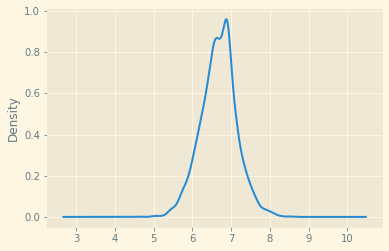

In [ ]:
df["lwage"].plot(kind="density")

In [ ]:
df["lwage_cat"] = pd.qcut(df["lwage"], [0, 0.5, 1], labels=[0, 1]).astype("int")

In [ ]:
X = np.array([df.loc[:,"exp":"id"].groupby('id').get_group(i).values[:,:-2] for i in range(1, 596)])
Y = np.array([df.loc[:,["id","lwage_cat"]].groupby('id').get_group(i).values[:,1:] for i in range(1, 596)])

In [ ]:
print(X.shape)
print(Y.shape)

(595, 7, 11)
(595, 7, 1)


In [ ]:
input_layer = Input(shape=(7,11,))
encoder = LSTM(32, return_sequences=True)(input_layer)
decoder = LSTM(32, return_sequences=True)(encoder)
output = TimeDistributed(Dense(1, activation="sigmoid"))(decoder)
model = Model(inputs=input_layer, outputs=output)

2022-07-11 23:33:54.456080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
hist = model.fit(X, Y, batch_size=32, epochs=100, verbose=0)

In [ ]:
Yh = model.predict(X)

19/19 [==============================] - 1s 2ms/step


In [ ]:
print(Y[0].reshape((-1)))
print(Yh[0].reshape((-1)).round(3))

[0 0 0 0 0 0 0]
[0.047 0.031 0.087 0.199 0.279 0.433 0.552]


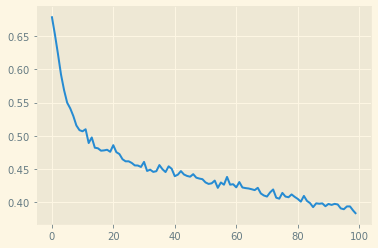

In [ ]:
plt.plot(hist.history["loss"])

In [ ]:
from panel_data_example import stratified_auc, auc_w

In [ ]:
outcome_data = pd.DataFrame()
outcome_data["outcome"] = df["lwage_cat"]
outcome_data["p"] = Yh.reshape((-1))
outcome_data["count"] = df["t"]

In [ ]:
stratified_auc(outcome_data)

,auc_i,N_i
count,,
1,0.905765,595.0
2,0.871754,595.0
3,0.857221,595.0
4,0.867608,595.0
5,0.898643,595.0
6,0.908257,595.0
7,0.924515,595.0


In [ ]:
auc_w(stratified_auc(outcome_data))

0.8905374578067233